# Recurrent Neural Networks

## Libraries

In [ ]:
# !pip install torch

In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import random
from scipy.signal import resample
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report

## Utilities

## Data

Dataset [MIT-BIH Arrhythmia Database](https://physionet.org/content/mitdb/1.0.0/), can be downloaded from Kaggle [here](https://www.kaggle.com/datasets/shayanfazeli/heartbeat).

In [2]:
# Read train data.
df_train = pd.read_csv("mitbih_train.csv", header=None)
df_train = df_train.reset_index().drop('index', axis='columns')

# Read test data.
df_test = pd.read_csv("mitbih_test.csv", header=None)
df_test = df_test.reset_index().drop('index', axis='columns')

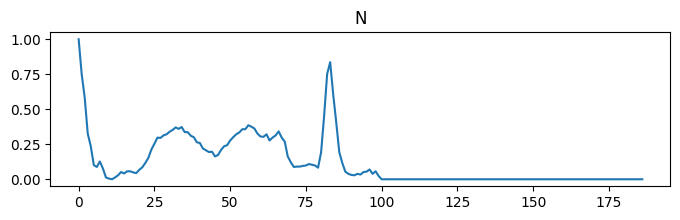

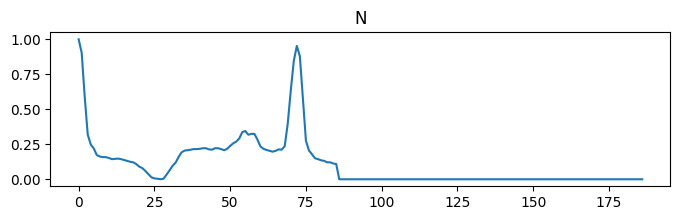

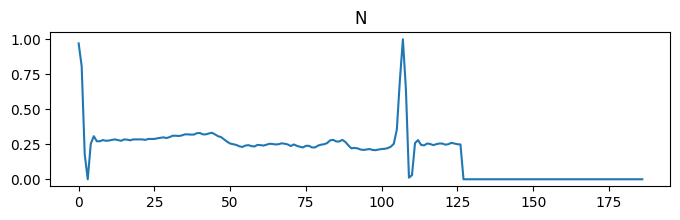

In [4]:
# From label index to label name.
labels_map = {
    0: 'N', # Normal
    1: 'S', # Fusion of paced and normal
    2: 'V', # Premature ventricular contraction
    3: 'F', # Atrial premature
    4: 'Q'  # Fusion of ventricular and normal
}

# Plot some data.
for _ in range(3):
    plt.figure(figsize=(8, 2))
    sample = df_train.sample(1).values.flatten()
    y = labels_map[sample[-1]]
    plt.plot(sample[:-1])
    plt.title(y)
plt.show()

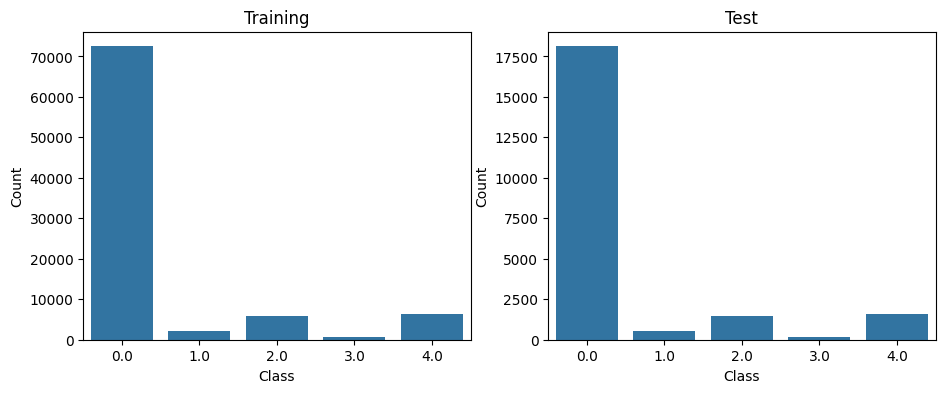

In [16]:
# Plot distributions.
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
sns.countplot(x=df_train[df_train.shape[1] - 1], ax=ax[0])
sns.countplot(x=df_test[df_test.shape[1] - 1], ax=ax[1])
ax[0].set_title('Training')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')
ax[1].set_title('Test')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')
plt.show()

## Model Definition

## Training and Test